In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.io import imread
from tqdm import tqdm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [2]:
#To consolodate all the wave dataframes in a set, use the following function: 
#INPUT: Sorted list of all wave dataframe csv locations:
#Option to save the DF as a csv in the relevant location is given, default is False
#OUTPUT: A dataframe containing all of the csv wave DFs in the path list

def consolidate_waves(WAVE_DF_PATHS, save_DF = False):
    
    wave_collect = []

    for wave_df_path in tqdm(WAVE_DF_PATHS):
        img_id = int(wave_df_path.stem.split('_')[0]) #Get the image ID to match to the wave:
        wave_df = pd.read_csv(wave_df_path, converters={"wave_centroid": read_tuple_list}) #Open the wave_DF from step4 analysis
        wave_df = wave_df[wave_df.columns.drop(list(wave_df.filter(regex='Unnamed')))] #Strip it of any weird unnamed index columns
        track_ids = wave_df['clTrackID'].values #Get the collective track values in the wave
        wave_df['wave_ID'] = [str(img_id) + '-' + str(i) for i in track_ids] #Build a list of unique wave IDs from the image number and clTrack number they belong to
        wave_df['image_ID'] = [img_id for i in range(len(wave_df))]
        wave_collect.append(wave_df)
    
    wave_df_collected = pd.concat(wave_collect, ignore_index=True)
    
    if save_DF:
        wave_df_collected.to_csv(WAVE_DF_PATHS[0].parent / 'combined_wave_DF.csv', index=False)
        
    return wave_df_collected

#Custom function to read in centroid arrays into dataframe instead of as a string: 
def read_tuple_list(x):
    x_strip = x.strip('()').strip('[]')
    if len(x_strip.split(', ')) == 1:
        return np.array(x_strip.split(), dtype=float)
    else:
        return np.array(x_strip.split(', '), dtype=float)

In [3]:
#Lets import an arcos set, wave data, and the corresponding tracking data...
#base_path = Path('/media/echo/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
base_path = Path('/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Data Sets/2023_01_24_main-set')
images_folder = base_path / 'images'
analysis_output_destination = base_path / 'wavefit_outputs'

wave_dataframe_paths = sorted(analysis_output_destination.glob('*_wave_df.csv'), key=lambda x: x.stem.split('_')[0])

um_per_px = 2.2

In [4]:
wave_con_df = consolidate_waves(wave_dataframe_paths)

100%|██████████████████████████████████████████| 57/57 [00:00<00:00, 177.11it/s]


In [5]:
wave_con_df

,clTrackID,timepoint,rel_time,rel_r,r_squared,circle_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,ca_avg_sig,split,trackable,drug_name,drug_dose,volunteer_ID,wave_ID,image_ID
0,1,149,0,0.000000,0.000000,28.122055,6.039601,-0.361129,"[178.09090909, 174.86363636]",11421.345780,489.820783,0.0,True,NaN,NaN,1,26-1,26
1,1,150,1,30.198005,911.919531,58.320061,4.233955,-0.413879,"[177.48961702, 172.68330638]",11434.555375,518.768631,0.0,True,NaN,NaN,1,26-1,26
2,1,151,2,42.339551,1792.637540,70.461606,1.900812,-0.292453,"[180.88499599, 171.77675874]",11418.043382,561.317467,0.0,True,NaN,NaN,1,26-1,26
3,1,152,3,49.206124,2421.242601,77.328179,1.309421,-0.038660,"[179.45016358, 170.90562819]",11419.694581,600.793731,0.0,True,NaN,NaN,1,26-1,26
4,1,153,4,55.433765,3072.902281,83.555820,1.514213,0.015174,"[180.07921967, 169.76619812]",11429.601777,623.990896,0.0,True,NaN,NaN,1,26-1,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10323,17,268,8,46.291821,2142.932649,100.320753,0.238594,0.003805,"[202.85006327320022, 244.2334337260981]",8919.108663,622.558742,1.0,False,NaN,NaN,16,88-17,88
10324,17,269,9,46.021254,2117.955787,100.050187,0.138888,-0.008777,"[203.15059812202708, 244.17566282910545]",8938.797645,617.825159,1.0,False,NaN,NaN,16,88-17,88
10325,17,270,10,47.680702,2273.449365,101.709635,0.150820,0.023207,"[201.9351509841762, 244.69640154638017]",8941.610356,618.055417,1.0,False,NaN,NaN,16,88-17,88
10326,17,271,11,47.529453,2259.048892,101.558386,0.370953,0.062134,"[202.0603229568438, 244.62342147199797]",8935.984933,612.895955,1.0,False,NaN,NaN,16,88-17,88


In [6]:
max_radii = wave_con_df.groupby('wave_ID').circle_radius.max()

waves_max_radii_only = pd.merge(wave_con_df, max_radii).rename(columns={'circle_radius':'max_radius'})


In [43]:
#Can find waves in a range of final radii, look at density to find representative examples. 
max_radius_group = waves_max_radii_only[waves_max_radii_only['max_radius'].between(300,400)]
max_radius_group[max_radius_group['cell_density'].between(3000,4000)]

,clTrackID,timepoint,rel_time,rel_r,r_squared,max_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,ca_avg_sig,split,trackable,drug_name,drug_dose,volunteer_ID,wave_ID,image_ID
31,3,166,31,263.056993,69198.981744,303.452768,0.073254,-0.027638,"[267.6347762664604, 228.54545628900595]",3970.142503,311.275658,1.0,True,NaN,NaN,17,35-3,35
117,70,240,27,290.348945,84302.509656,386.190474,0.118441,-0.025176,"[181.01055360528048, 248.3889325945521]",3437.439484,368.778630,1.0,True,NaN,NaN,8,46-70,46
120,68,162,34,179.639369,32270.302790,332.641808,-0.045474,-0.014028,"[201.57272260873955, 256.2291881377322]",3580.175627,364.013751,1.0,False,NaN,NaN,8,46-68,46
266,4,147,38,262.455195,68882.729448,334.828646,0.075784,-0.021267,"[202.41906346431205, 179.38111487454066]",3105.233669,369.998791,1.0,True,NaN,NaN,8,69-4,69
267,60,200,48,285.091190,81276.986763,397.467772,0.016392,-0.003600,"[210.14831385881766, 225.398470321091]",3130.548074,367.356215,1.0,True,NaN,NaN,8,69-60,69
268,61,278,71,203.512395,41417.295003,362.040544,0.086487,-0.008751,"[197.08919765724153, 212.7283251843843]",3217.742135,375.823288,1.0,False,NaN,NaN,8,69-61,69
269,1,157,40,242.155138,58639.111087,303.253573,0.283107,-0.001477,"[241.84431242153914, 226.4544653639324]",3040.541301,323.936984,1.0,True,NaN,NaN,8,70-1,70
308,25,297,54,162.595722,26437.368731,326.104613,-0.000918,-0.013353,"[210.45070775359108, 231.06042716144532]",3923.732761,339.650293,1.0,False,NaN,NaN,8,75-25,75
339,2,119,20,247.570214,61291.010750,306.706321,0.080151,-0.017722,"[182.35279804891704, 172.42484264465597]",3030.696810,375.110976,1.0,True,NaN,NaN,16,81-2,81
356,3,117,24,228.957265,52421.429373,317.348806,0.055983,-0.029155,"[183.4997796190891, 221.08758962616216]",3134.767141,313.139745,1.0,True,NaN,NaN,16,83-3,83


In [8]:
#Good example at 82-29, 70-10, 84-39:
waves_max_radii_only[waves_max_radii_only['wave_ID']=='84-39']

,clTrackID,timepoint,rel_time,rel_r,r_squared,max_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,ca_avg_sig,split,trackable,drug_name,drug_dose,volunteer_ID,wave_ID,image_ID
367,39,241,13,74.071671,5486.612461,242.321739,0.58595,0.030977,"[199.94136908998695, 212.7745382005175]",2306.423558,357.455946,1.0,False,NaN,NaN,16,84-39,84


In [129]:
wave_ID_str = '83-3'
image_num = str(83)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))
raw_tif = imread(images_folder / '{}.tif'.format(image_num))

#Lets select the example wave: (#image number: wave number)
ex_wave_num = 3 #57:6, 88:5, 45:19, 58:6
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]

export_location = '/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Supplement 4/stills/'
vmin_set = 175
vmax_set = 800
crop_buffer = 175 #57:100px, 81:160px,
border_color = '#B54845'
border_width = 10


ex_time = ex_wave_DF.iloc[ex_wave_DF['circle_radius'].argmax()].timepoint #Get the timepoint where the radius is at max (normally last point)

ex_arcos_timepoint = ex_arcos_DF[ex_arcos_DF['timepoint'] < ex_time]
initial_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
initial_wave_center = [int(val) for val in initial_wave_center]
i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/um_per_px

point_color = 'magenta'

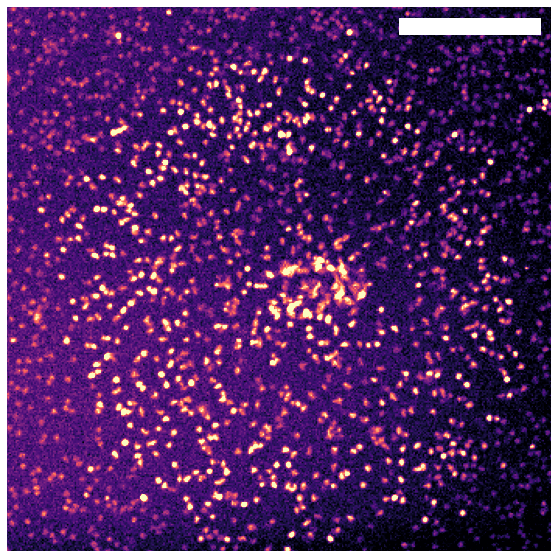

In [139]:
fig, ax = plt.subplots(figsize=(10,10))
vmin_set = 250
vmax_set = 500
ax.imshow(raw_tif[ex_time-5, 0,:,:], cmap='magma', vmin=vmin_set, vmax=vmax_set)
#sns.scatterplot(data=ex_arcos_timepoint, x='x', y='y', color=[0,0,0,0], edgecolor=point_color, s=75, linewidth=1, ax=ax)
plt.axis('off')
#Wave Limit Circle: 
#circle1 = plt.Circle(initial_wave_center, i_wave_r, color='white', fill=False, linestyle='--', linewidth=border_width)
#ax.add_patch(circle1)
plt.ylim(initial_wave_center[1]-crop_buffer,initial_wave_center[1]+crop_buffer)
plt.xlim(initial_wave_center[0]-crop_buffer,initial_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()

scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)
plt.savefig(export_location + 'fig4-max-radius-still-{}.png'.format(wave_ID_str), dpi=300, bbox_inches='tight')

In [140]:
wave_ID_str = '78-44'
image_num = str(78)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))
raw_tif = imread(images_folder / '{}.tif'.format(image_num))

#Lets select the example wave: (#image number: wave number)
ex_wave_num = 44 #57:6, 88:5, 45:19, 58:6
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]

export_location = '/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Supplement 4/stills/'
vmin_set = 175
vmax_set = 800
crop_buffer = 175 #57:100px, 81:160px,
border_color = '#B54845'
border_width = 10


ex_time = ex_wave_DF.iloc[ex_wave_DF['circle_radius'].argmax()].timepoint #Get the timepoint where the radius is at max (normally last point)

ex_arcos_timepoint = ex_arcos_DF[ex_arcos_DF['timepoint'] < ex_time]
initial_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
initial_wave_center = [int(val) for val in initial_wave_center]
i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/um_per_px

point_color = 'magenta'

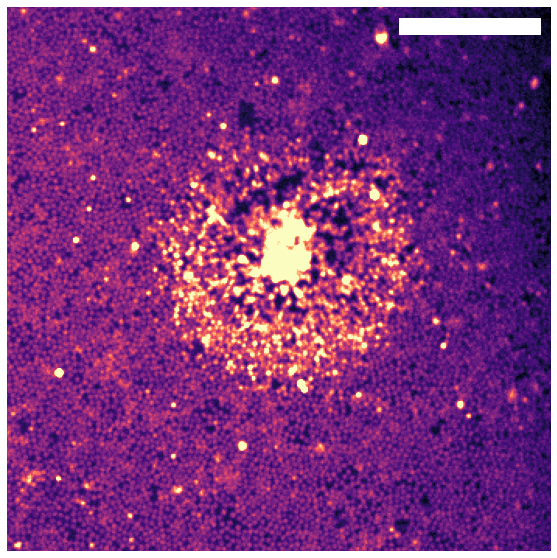

In [141]:
fig, ax = plt.subplots(figsize=(10,10))
vmin_set = 225
vmax_set = 800
ax.imshow(raw_tif[ex_time-5, 0,:,:], cmap='magma', vmin=vmin_set, vmax=vmax_set)
#sns.scatterplot(data=ex_arcos_timepoint, x='x', y='y', color=[0,0,0,0], edgecolor=point_color, s=75, linewidth=1, ax=ax)
plt.axis('off')
#Wave Limit Circle: 
#circle1 = plt.Circle(initial_wave_center, i_wave_r, color='white', fill=False, linestyle='--', linewidth=border_width)
#ax.add_patch(circle1)
plt.ylim(initial_wave_center[1]-crop_buffer,initial_wave_center[1]+crop_buffer)
plt.xlim(initial_wave_center[0]-crop_buffer,initial_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()

scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)
plt.savefig(export_location + 'fig4-max-radius-still-{}.png'.format(wave_ID_str), dpi=300, bbox_inches='tight')

In [ ]:
wave_ID_str = '84-39'
image_num = str(84) #57 used, 88 used, 45, 46, 58 used for supp

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))
raw_tif = imread(images_folder / '{}.tif'.format(image_num))

#Lets select the example wave: (#image number: wave number)
ex_wave_num = 39 #57:6, 88:5, 45:19, 58:6
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]

export_location = '/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Supplement 4/stills/'
vmin_set = 175
vmax_set = 800
crop_buffer = 150 #57:100px, 81:160px,
border_color = '#B54845'
border_width = 10


ex_time = ex_wave_DF.iloc[ex_wave_DF['circle_radius'].argmax()].timepoint #Get the timepoint where the radius is at max (normally last point)

ex_arcos_timepoint = ex_arcos_DF[ex_arcos_DF['timepoint'] < ex_time]
initial_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
initial_wave_center = [int(val) for val in initial_wave_center]
i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/um_per_px

point_color = 'magenta'

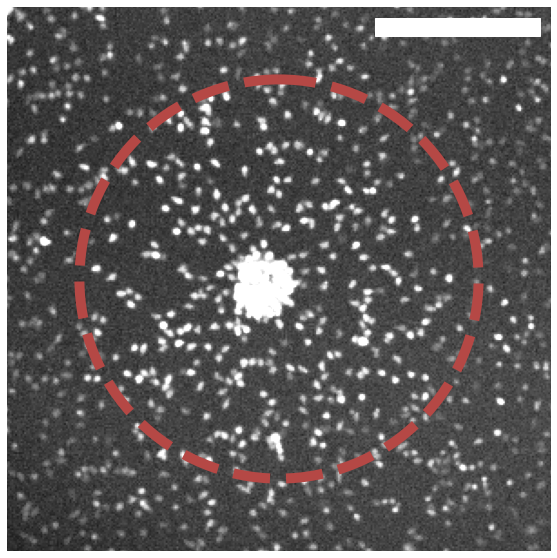

In [109]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(raw_tif[ex_time-6, 0,:,:], cmap='Greys_r', vmin=vmin_set, vmax=vmax_set)
#sns.scatterplot(data=ex_arcos_timepoint, x='x', y='y', color=[0,0,0,0], edgecolor=point_color, s=75, linewidth=1, ax=ax)
plt.axis('off')
#Wave Limit Circle: 
circle1 = plt.Circle(initial_wave_center, i_wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
ax.add_patch(circle1)
plt.ylim(initial_wave_center[1]-crop_buffer,initial_wave_center[1]+crop_buffer)
plt.xlim(initial_wave_center[0]-crop_buffer,initial_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()

scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)
plt.savefig(export_location + 'fig4-supp-max-radius-still-{}.png'.format(wave_ID_str), dpi=300, bbox_inches='tight')

In [89]:
#Can find waves in a range of final radii, look at density to find representative examples. 
max_radius_group = waves_max_radii_only[waves_max_radii_only['max_radius'].between(180,200)]
max_radius_group[max_radius_group['cell_density'].between(7500,8500)]

,clTrackID,timepoint,rel_time,rel_r,r_squared,max_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,ca_avg_sig,split,trackable,drug_name,drug_dose,volunteer_ID,wave_ID,image_ID
74,4,142,25,103.064143,10622.217632,180.037888,1.101860,0.074896,"[162.5874242303534, 206.36655240223146]",8311.562945,516.229571,1.0,True,NaN,NaN,17,40-4,40
75,14,339,25,115.878693,13427.871472,195.246058,0.288482,-0.085179,"[204.74955905321744, 212.70638650092584]",7954.348565,519.601729,1.0,True,NaN,NaN,17,40-14,40
222,10,198,10,138.610502,19212.871216,185.519316,0.450599,-0.096071,"[200.04394650447168, 231.9228823590036]",7989.507460,343.355399,1.0,True,NaN,NaN,18,63-10,63
375,89,198,35,93.382780,8720.343605,182.909816,0.421056,-0.070401,"[174.86733183443872, 179.16463294393037]",8414.226921,513.348948,0.0,False,NaN,NaN,16,85-89,85
376,89,199,36,93.382780,8720.343605,182.909816,-0.282951,-0.098696,"[174.86733183443872, 179.16463294393037]",8329.845571,521.806181,0.0,False,NaN,NaN,16,85-89,85
377,90,209,8,38.830990,1507.845807,185.288515,0.001108,-0.042952,"[212.0690583667579, 193.33325522230896]",8380.474381,505.481887,1.0,False,NaN,NaN,16,85-90,85


In [83]:
#Good example at 40-14:
waves_max_radii_only[waves_max_radii_only['wave_ID']=='40-14']

,clTrackID,timepoint,rel_time,rel_r,r_squared,max_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,ca_avg_sig,split,trackable,drug_name,drug_dose,volunteer_ID,wave_ID,image_ID
75,14,339,25,115.878693,13427.871472,195.246058,0.288482,-0.085179,"[204.74955905321744, 212.70638650092584]",7954.348565,519.601729,1.0,True,NaN,NaN,17,40-14,40


In [103]:
wave_ID_str = '40-14'
image_num = str(40) #57 used, 88 used, 45, 46, 58 used for supp

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))
raw_tif = imread(images_folder / '{}.tif'.format(image_num))

#Lets select the example wave: (#image number: wave number)
ex_wave_num = 14 #57:6, 88:5, 45:19, 58:6
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]

export_location = '/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Supplement 4/stills/'
vmin_set = 175
vmax_set = 800
crop_buffer = 150 #57:100px, 81:160px,
border_color = '#B54845'
border_width = 10


ex_time = ex_wave_DF.iloc[ex_wave_DF['circle_radius'].argmax()].timepoint #Get the timepoint where the radius is at max (normally last point)

ex_arcos_timepoint = ex_arcos_DF[ex_arcos_DF['timepoint'] < ex_time]
initial_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
initial_wave_center = [int(val) for val in initial_wave_center]
i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/um_per_px

point_color = 'magenta'

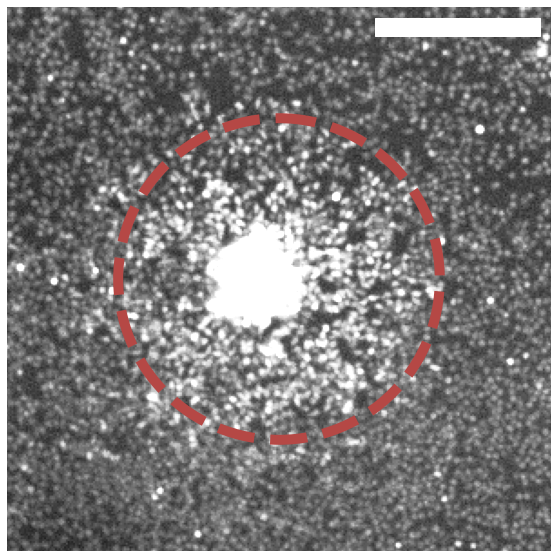

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(raw_tif[ex_time-6, 0,:,:], cmap='Greys_r', vmin=vmin_set, vmax=vmax_set)
#sns.scatterplot(data=ex_arcos_timepoint, x='x', y='y', color=[0,0,0,0], edgecolor=point_color, s=75, linewidth=1, ax=ax)
plt.axis('off')
#Wave Limit Circle: 
circle1 = plt.Circle(initial_wave_center, i_wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
ax.add_patch(circle1)
plt.ylim(initial_wave_center[1]-crop_buffer,initial_wave_center[1]+crop_buffer)
plt.xlim(initial_wave_center[0]-crop_buffer,initial_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()

scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)
plt.savefig(export_location + 'fig4-supp-max-radius-still-{}.png'.format(wave_ID_str), dpi=300, bbox_inches='tight')

In [109]:
#Can find waves in a range of final radii, look at density to find representative examples. 
max_radius_group = waves_max_radii_only[waves_max_radii_only['max_radius'].between(140,180)]
max_radius_group[max_radius_group['cell_density'].between(12500,14500)]

,clTrackID,timepoint,rel_time,rel_r,r_squared,max_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,ca_avg_sig,split,trackable,drug_name,drug_dose,volunteer_ID,wave_ID,image_ID
88,3,134,23,109.535046,11997.926345,141.730201,0.041499,-0.017226,"[176.03482426815506, 186.41324147884464]",13970.738798,579.074321,1.0,False,NaN,NaN,8,41-3,41
108,52,407,10,57.755836,3335.736580,141.815000,-0.035935,-0.023543,"[198.6025205742333, 231.86915525703952]",14028.399387,458.955040,1.0,False,NaN,NaN,8,44-52,44
169,18,401,19,112.769965,12717.064921,158.888508,-0.048901,-0.013105,"[170.05134179951878, 201.41035105390608]",13342.097743,485.756150,1.0,True,NaN,NaN,18,53-18,53
170,19,421,12,105.375334,11103.960998,156.046924,0.011138,-0.028198,"[198.9946064558467, 192.9279035587821]",13306.938847,509.400190,1.0,True,NaN,NaN,18,53-19,53
183,5,189,43,90.858331,8255.236395,150.790245,0.349430,-0.000189,"[177.5765392439172, 241.37868281626513]",12775.336344,447.731150,1.0,False,NaN,NaN,18,56-5,56
185,18,359,15,101.411430,10284.278198,169.816150,0.185675,-0.034100,"[169.2161131863752, 239.62916392958803]",12792.212614,435.845254,1.0,False,NaN,NaN,18,56-18,56
320,16,695,10,39.158323,1533.374270,163.589639,0.157349,-0.035925,"[203.0, 186.0]",14173.254037,552.293075,1.0,False,NaN,NaN,16,77-16,77
322,44,236,20,113.652777,12916.953615,174.350746,0.079375,0.004750,"[209.4209008386228, 222.95379537161588]",13097.391829,483.506309,1.0,True,NaN,NaN,16,78-44,78
324,6,212,27,87.503336,7656.833737,150.723290,0.005284,-0.001875,"[216.01445948223233, 198.01247731209443]",13260.529105,476.812826,1.0,False,NaN,NaN,16,78-6,78
325,7,264,24,127.469933,16248.583786,160.716566,0.132553,-0.016562,"[209.04471275674106, 187.1386852998321]",12920.190994,506.151965,1.0,False,NaN,NaN,16,78-7,78


In [94]:
#Good example at 79-27:
waves_max_radii_only[waves_max_radii_only['wave_ID']=='78-6']

,clTrackID,timepoint,rel_time,rel_r,r_squared,max_radius,radius_velocity,radius_acceleration,wave_centroid,cell_density,ca_avg_sig,split,trackable,drug_name,drug_dose,volunteer_ID,wave_ID,image_ID
324,6,212,27,87.503336,7656.833737,150.72329,0.005284,-0.001875,"[216.01445948223233, 198.01247731209443]",13260.529105,476.812826,1.0,False,NaN,NaN,16,78-6,78


In [95]:
wave_ID_str = '78-6'
image_num = str(78)

wave_df = pd.read_csv(analysis_output_destination / '{}_wave_df.csv'.format(image_num), converters={"wave_centroid": read_tuple_list})
arcos_df = pd.read_csv(analysis_output_destination / '{}_ARCOS_df.csv'.format(image_num))
tracking_df = pd.read_csv(analysis_output_destination / '{}_tracking_binned_df.csv'.format(image_num))
raw_tif = imread(images_folder / '{}.tif'.format(image_num))

#Lets select the example wave: (#image number: wave number)
ex_wave_num = 6 #57:6, 88:5, 45:19, 58:6
ex_wave_DF = wave_df[wave_df['clTrackID']==ex_wave_num]
ex_arcos_DF = arcos_df[arcos_df['clTrackID']==ex_wave_num]

export_location = '/Volumes/Samsung_T5/Main Data/Analysis Sets/23 Protofigures/Supplement 4/stills/'
vmin_set = 175
vmax_set = 800
crop_buffer = 150 #57:100px, 81:160px,
border_color = '#B54845'
border_width = 10


ex_time = ex_wave_DF.iloc[ex_wave_DF['circle_radius'].argmax()].timepoint #Get the timepoint where the radius is at max (normally last point)

ex_arcos_timepoint = ex_arcos_DF[ex_arcos_DF['timepoint'] < ex_time]
initial_wave_center = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].wave_centroid.values[0]
initial_wave_center = [int(val) for val in initial_wave_center]
i_wave_r = ex_wave_DF[ex_wave_DF['timepoint']==ex_time].circle_radius.values[0]/um_per_px

point_color = 'magenta'

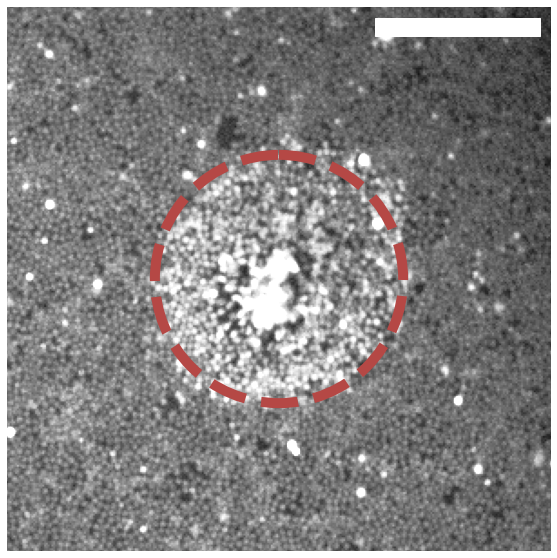

In [102]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(raw_tif[ex_time-6, 0,:,:], cmap='Greys_r', vmin=vmin_set, vmax=vmax_set)
#sns.scatterplot(data=ex_arcos_timepoint, x='x', y='y', color=[0,0,0,0], edgecolor=point_color, s=75, linewidth=1, ax=ax)
plt.axis('off')
#Wave Limit Circle: 
circle1 = plt.Circle(initial_wave_center, i_wave_r, color=border_color, fill=False, linestyle='--', linewidth=border_width)
ax.add_patch(circle1)
plt.ylim(initial_wave_center[1]-crop_buffer,initial_wave_center[1]+crop_buffer)
plt.xlim(initial_wave_center[0]-crop_buffer,initial_wave_center[0]+crop_buffer)
plt.gca().invert_yaxis()

scalebar = AnchoredSizeBar(ax.transData,
                           200/um_per_px, '',  'upper right', 
                           pad=1,
                           color='white',
                           frameon=False,
                           size_vertical=10)

ax.add_artist(scalebar)
plt.savefig(export_location + 'fig4-supp-max-radius-still-{}.png'.format(wave_ID_str), dpi=300, bbox_inches='tight')